In [1]:
import itertools
import math
import random
import requests
from pydantic import BaseModel, constr
from typing import Optional, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from scipy.spatial import KDTree
import geopandas as gpd
from shapely.geometry import Point
from IPython.display import display
from matplotlib.ticker import MultipleLocator

%config InlineBackend. figure_format = 'retina'
sns.set()

BASE_URL = 'https://sherlock.aerobotics.com/developers'
API_TOKEN = '1566394169B0EJX2MGAVKVUGGKEMKZBMND9A7VCR'
orchid_id = 216269

In [2]:
class TreeSurvey(BaseModel):
    id: int
    survey_id: int
    latitude: float
    longitude: float
    radius: float
    ndre: float
    ndvi: float
    height: float
    area: float

class Survey(BaseModel):
    id: int
    hectares: float
    orchard_id: int
    date: str  # Assuming date is in a string format like 'YYYY-MM-DD'
    upload_id: int

class Orchard(BaseModel):
    id: int
    hectares: float
    name: constr(min_length=1, max_length=40)
    farm_id: int
    client_id: int
    polygon: str  # Assuming this is a string representation of the polygon data
    crop_type: constr(min_length=1)

class TreeSurveyResponse(BaseModel):
    count: int
    next: Optional[constr(min_length=1)]
    previous: Optional[constr(min_length=1)]
    results: List[TreeSurvey]

In [3]:

def get_treesurvey(orchard_id: str, api_token: str) -> TreeSurveyResponse:
    url = f"{BASE_URL}/treesurveys/?survey__orchard_id={orchard_id}"
    headers = {
        "accept": "application/json",
        "Authorization": api_token,
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        try:
            return TreeSurveyResponse.model_validate(response.json())
        except Exception as e:
            raise ValueError(f"Failed to parse response data: {e}")
    else:
        response.raise_for_status()

# Example usage
try:
    orchard_id = "216269"
    api_token = "1566394169B0EJX2MGAVKVUGGKEMKZBMND9A7VCR"
    result = get_treesurvey(orchard_id, api_token)
    print(result)
except Exception as e:
    print(f"Error: {e}")


count=508 next=None previous=None results=[TreeSurvey(id=54733434, survey_id=25319, latitude=-32.3279643, longitude=18.826872, radius=2.0, ndre=0.557, ndvi=0.872, height=3.25, area=22.667), TreeSurvey(id=54733276, survey_id=25319, latitude=-32.3281893, longitude=18.8263421, radius=2.0, ndre=0.559, ndvi=0.881, height=2.422, area=22.662), TreeSurvey(id=54733233, survey_id=25319, latitude=-32.3283205, longitude=18.8256169, radius=2.0, ndre=0.57, ndvi=0.888, height=2.949, area=25.908), TreeSurvey(id=54733009, survey_id=25319, latitude=-32.3287595, longitude=18.8262246, radius=2.0, ndre=0.499, ndvi=0.84, height=2.382, area=16.451), TreeSurvey(id=54733324, survey_id=25319, latitude=-32.3280753, longitude=18.8255473, radius=2.0, ndre=0.555, ndvi=0.869, height=3.178, area=25.914), TreeSurvey(id=54733279, survey_id=25319, latitude=-32.3280162, longitude=18.8263217, radius=2.0, ndre=0.572, ndvi=0.884, height=2.242, area=22.037), TreeSurvey(id=54733259, survey_id=25319, latitude=-32.3279874, long

<Axes: >

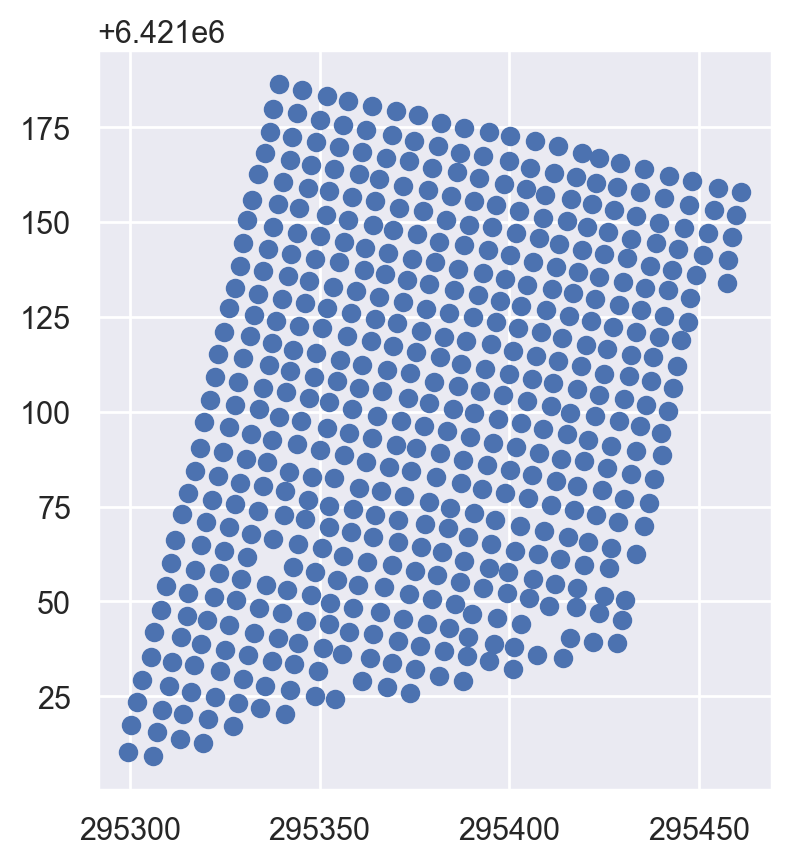

In [4]:
def treesurvey_to_dataframe(treesurvey_response: TreeSurveyResponse) -> pd.DataFrame:
    data = [treesurvey.model_dump() for treesurvey in treesurvey_response.results]
    df = pd.DataFrame(data)
    return df



df = treesurvey_to_dataframe(result)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))
gdf.to_crs(gdf.estimate_utm_crs(), inplace=True)
gdf.plot()

In [5]:
gdf

,id,survey_id,latitude,longitude,radius,ndre,ndvi,height,area,geometry
0,54733434,25319,-32.327964,18.826872,2.0,0.557,0.872,3.250,22.667,POINT (295449.295 6421135.967)
1,54733276,25319,-32.328189,18.826342,2.0,0.559,0.881,2.422,22.662,POINT (295399.913 6421110.006)
2,54733233,25319,-32.328320,18.825617,2.0,0.570,0.888,2.949,25.908,POINT (295331.933 6421094.072)
3,54733009,25319,-32.328759,18.826225,2.0,0.499,0.840,2.382,16.451,POINT (295390.134 6421046.556)
4,54733324,25319,-32.328075,18.825547,2.0,0.555,0.869,3.178,25.914,POINT (295324.828 6421121.127)
...,...,...,...,...,...,...,...,...,...,...
503,54733043,25319,-32.328779,18.826644,2.0,0.484,0.817,2.424,11.123,POINT (295429.700 6421045.196)
504,54733370,25319,-32.327872,18.826154,2.0,0.564,0.876,2.707,19.976,POINT (295381.452 6421144.829)
505,54732982,25319,-32.328519,18.825960,2.0,0.560,0.876,3.276,23.513,POINT (295364.644 6421072.728)
506,54733352,25319,-32.327738,18.826340,2.0,0.569,0.887,2.647,26.120,POINT (295398.737 6421160.055)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import line
from scipy.ndimage import gaussian_filter
from skimage.draw import disk

404 436


Text(0.5, 1.0, 'Original Image')

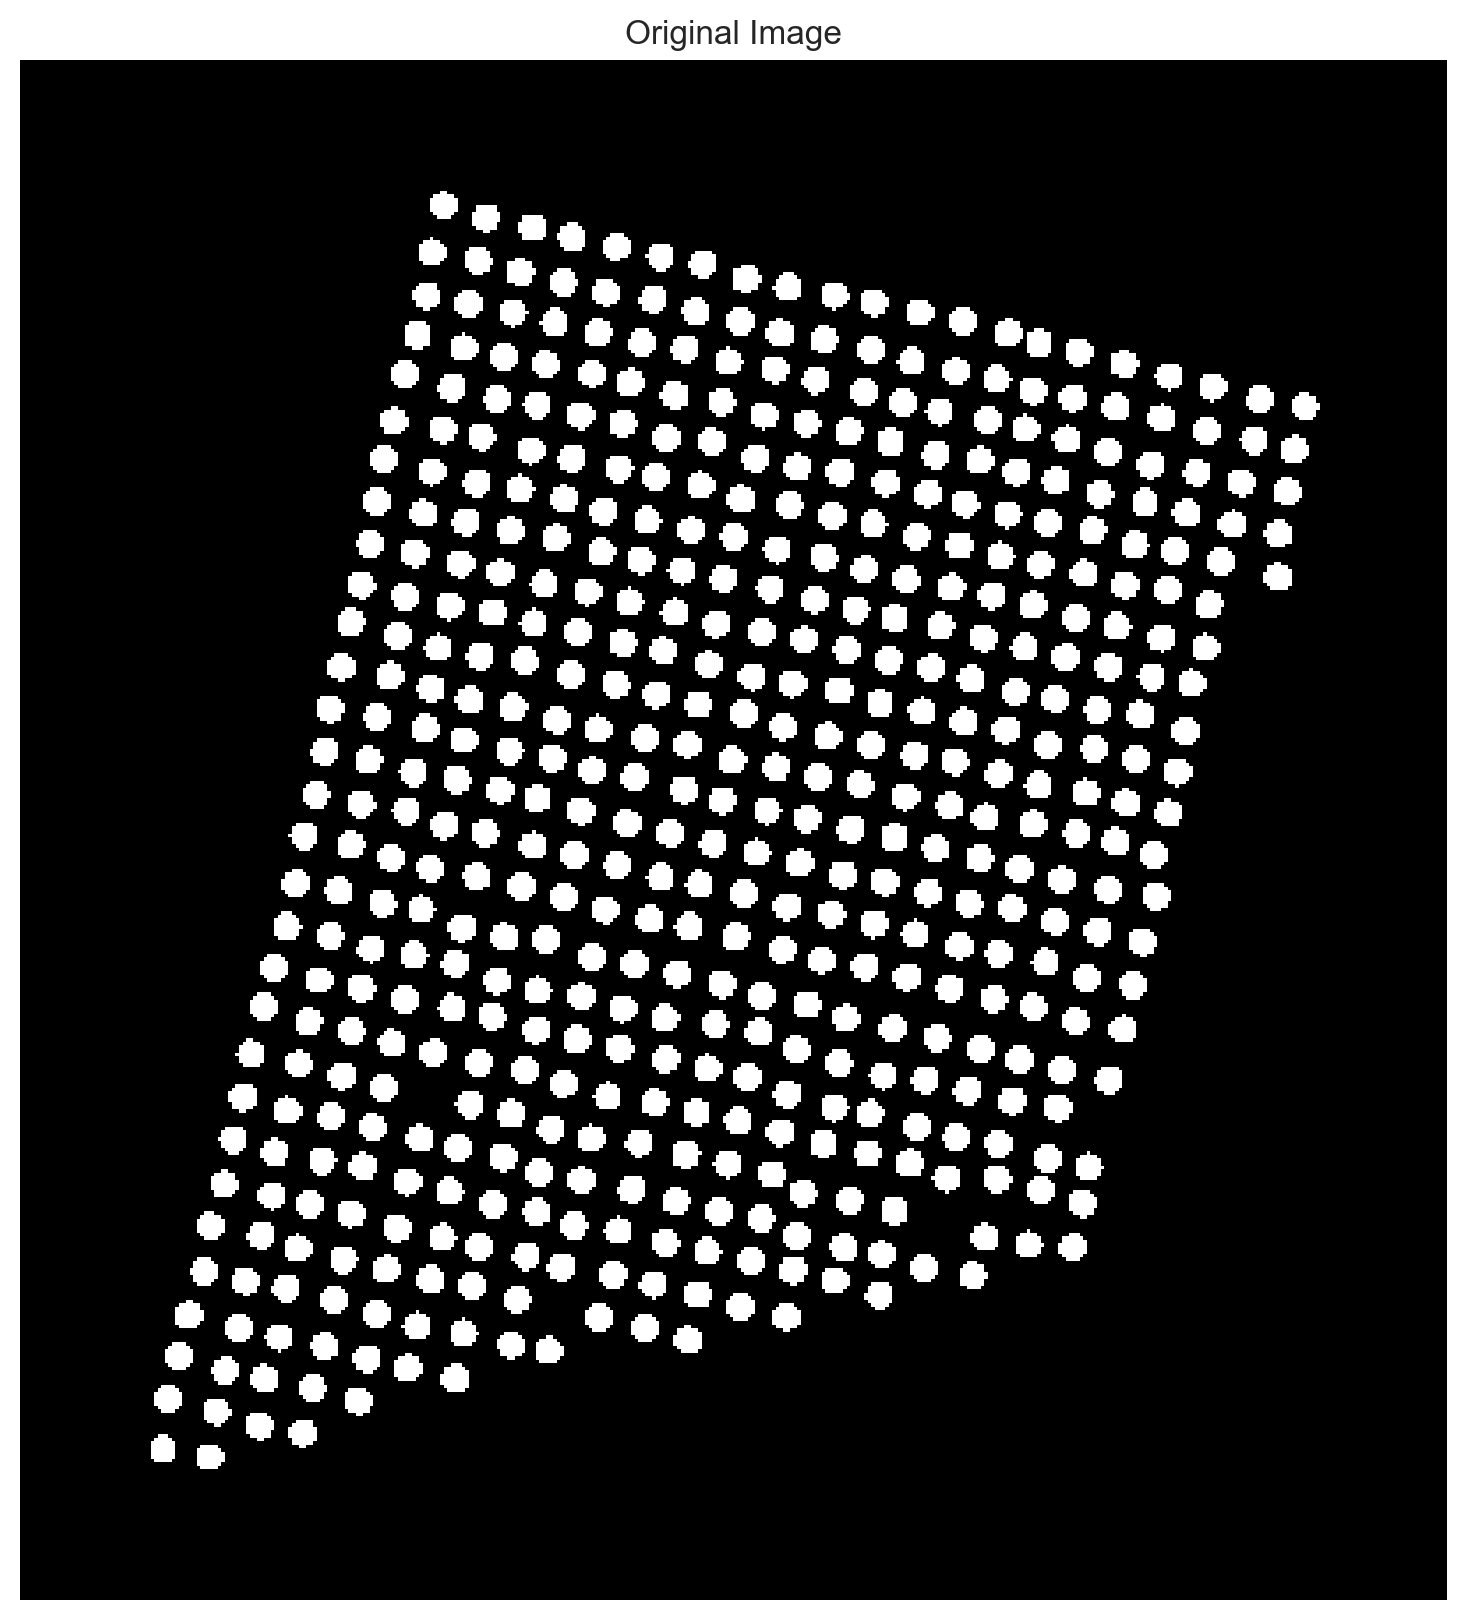

In [182]:
xy = np.column_stack((gdf.geometry.x, gdf.geometry.y))
radii = 4*np.ones(len(xy))
buffer = 5*np.max(radii)
points = xy - np.min(xy, axis=0) + buffer

width, height = np.ceil(np.max(points, axis=0) + buffer).astype(int) * 2
print(width, height)
image = np.zeros((height, width))
for p, r in zip(points, radii):
    cc, rr = disk(p*2, r)
    image[rr,cc]+=1

# Plot the original image
plt.subplots(1,1, figsize=(10,10))
plt.imshow(image, cmap='gray', origin='lower')
plt.axis('off')
plt.title('Original Image')

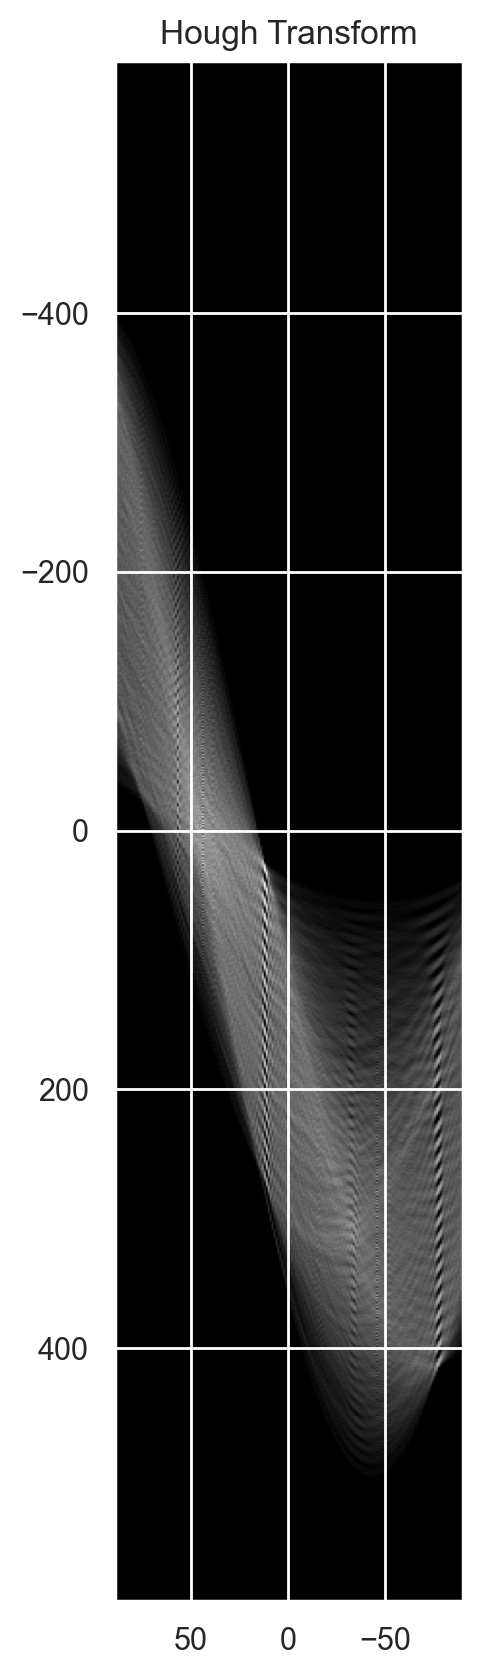

In [183]:
# Compute the Hough Transform
h, theta, d = hough_line(image)

# Plot the Hough Transform
plt.subplots(1,1, figsize=(10,10))
# plt.axis('off')
plt.imshow(h,
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
           cmap='gray', aspect=1/1.5)
plt.title('Hough Transform')
plt.show()



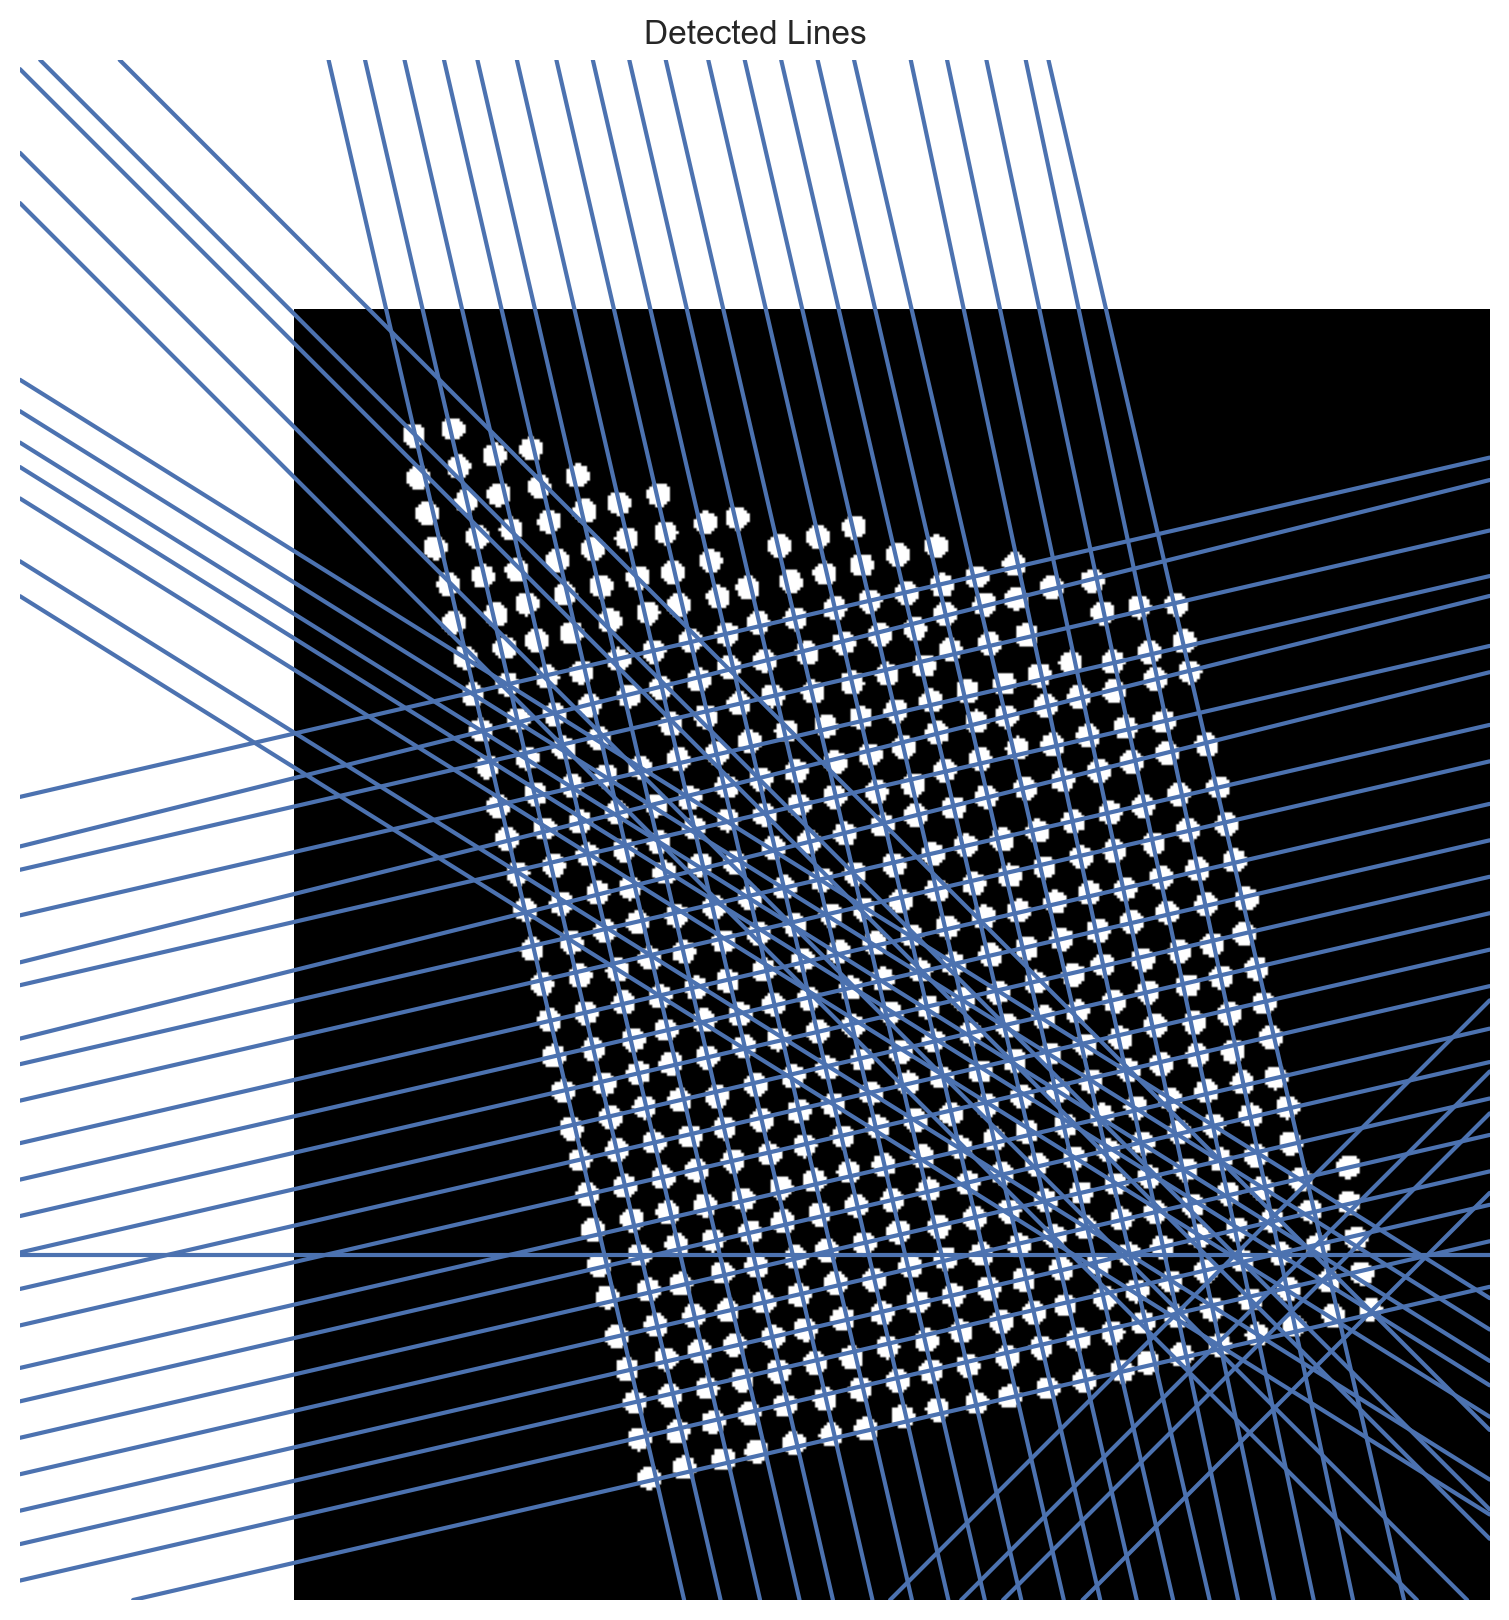

In [184]:
# # Detect peaks in the Hough Transform
# for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
#     y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
#     y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
#     rr, cc = line(int(y0), 0, int(y1), image.shape[1] - 1)
#     image[rr, cc] = True  # Draw lines on the original image


plt.subplots(1,1,figsize=(10,10))
plt.imshow(image, cmap='gray')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=6, min_angle=60, threshold=1.1)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    plt.gca().axline((x0, y0), slope=np.tan(angle + np.pi/2))

# Plot the original image with detected lines

plt.title('Detected Lines')
plt.axis('off')
plt.show()